# Etape 1 : Exploration des données

Dans cette étape, nous explorons les données du dataset dataset_big_patent_v1.json suivant différents axes : 

- analyses basiques sur le contenu des documents
- analyses des différentes sections composant le brevet

In [1]:
import json
import seaborn as sns
from nltk.corpus import stopwords
from collections import  Counter
import matplotlib.pyplot as plt
import numpy as np

### Chargement du dataset

In [2]:
with open('/Users/mbp004/dev/test_yxir/data/dataset_big_patent_v1.json') as f:
    data = json.load(f)

### Analyses exploratoires basiques
On regarde des indicateurs de base sur les donnees (brevet+abstract) : 
- mots les plus frequents
- longueur des documents

In [3]:
# Construction simplifiee d'un corpus pour l'analyse
corpus = []
for i in range(len(data)):
    corpus.append(data[i]['negative'])
    corpus.append(data[i]['pos'])

<Axes: >

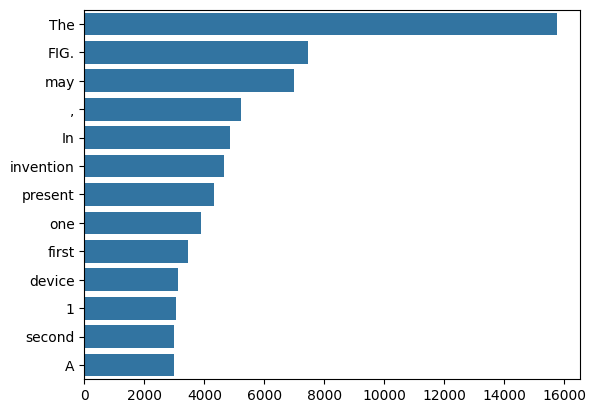

In [4]:
# Affichage des mots les plus frequents, exceptes les stop words
stop=set(stopwords.words('english'))
corpus_words = []
for text in corpus:
    new= text.split()
    corpus_words+=new
counter=Counter(corpus_words)
most=counter.most_common()
x, y=[], []
for word,count in most[:40]:
    if (word not in stop):
        x.append(word)
        y.append(count)
        
sns.barplot(x=y,y=x)

/var/folders/7d/q4n92n2n2_d49gm_83s92yyh0000gp/T/ipykernel_3112/3284534153.py:11: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


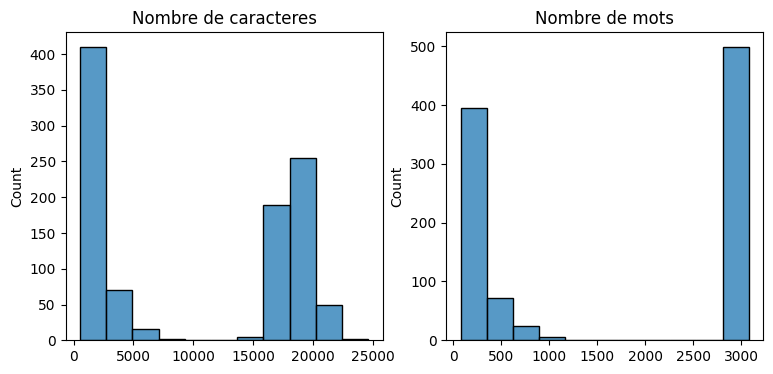

In [5]:
# Repartition sur la taille des documents
corpus_character_length = [len(text) for text in corpus]
corpus_words_length = [len(text.split()) for text in corpus]
fig, ax = plt.subplots(1,2)
fig.set_figheight(4)
fig.set_figwidth(9)
sns.histplot(data=corpus_character_length, ax=ax[0])
sns.histplot(data=corpus_words_length, ax=ax[1])
ax[0].set_title('Nombre de caracteres')
ax[1].set_title('Nombre de mots')
fig.show()

### Focus sur les differentes sections des brevets
On infère les différentes sections contenues dans les brevets et on fait quelques stats sur les sections : 
- listing des sections trouvées
- Sur les documents : Combien d'abstracts VS contenus de brevets
- longueur moyennes des différentes sections

In [6]:
# Inference des differents noms de section possible dans un brevet
sections_candidates = []

for text in corpus:
    list_candidate = []
    for word in text.split():
        if (word.isupper() and len(word)>1):
            list_candidate.append(word)
        else:
            if len(list_candidate)>0:
                sections_candidates.append(' '.join(list_candidate))
            list_candidate = []

sections_counter = Counter(sections_candidates)
# A partir de ce counter on infere les noms de sections suivants:

list_all_patent_sections = [
    'CROSS-REFERENCE TO RELATED APPLICATIONSDETAILED DESCRIPTION OF THE PREFERRED EMBODIMENTS',
    'STATEMENT REGARDING FEDERALLY SPONSORED RESEARCH OR DEVELOPMENT',
    'BRIEF DESCRIPTION OF THE SEVERAL VIEWS OF THE DRAWINGS',
    'DETAILED DESCRIPTION OF THE PREFERRED EMBODIMENT',
    'STATEMENT REGARDING FEDERALLY SPONSORED RESEARCH',
    'DETAILED DESCRIPTION OF PREFERRED EMBODIMENTS',
    'DETAILED DESCRIPTION OF THE INVENTION FIG.',
    'CROSS REFERENCES TO RELATED APPLICATIONS',
    'BRIEF DESCRIPTION OF THE DRAWING FIGURES',
    'CROSS REFERENCE TO RELATED APPLICATIONS',
    'DESCRIPTION OF THE PREFERRED EMBODIMENT',
    'DETAILED DESCRIPTION OF THE EMBODIMENTS',
    'BACKGROUND AND SUMMARY OF THE INVENTION',
    'CROSS-REFERENCE TO RELATED APPLICATION',
    'CROSS REFERENCE TO RELATED APPLICATION',
    'DETAILED DESCRIPTION OF THE INVENTION',
    'OBJECTS AND SUMMARY OF THE INVENTION',
    'DETAILED DESCRIPTION OF EMBODIMENTS',
    'BRIEF DESCRIPTION OF THE DRAWING(S)',
    'DESCRIPTION OF PREFERRED EMBODIMENT',
    'BRIEF DESCRIPTION OF THE INVENTION',
    'BRIEF DESCRIPTION OF THE DRAWINGS',
    'DESCRIPTION OF THE DRAWINGS FIG.',
    'BRIEF DESCRIPTION OF THE FIGURES',
    'TECHNICAL FIELD OF THE INVENTION',
    'BRIEF DESCRIPTION OF THE DRAWING',
    'BRIEF SUMMARY OF THE INVENTION',
    'DESCRIPTION OF THE RELATED ART',
    'BRIEF DESCRIPTION OF DRAWINGS',
    'DESCRIPTION OF THE PRIOR ART',
    'DESCRIPTION OF THE INVENTION',
    'BRIEF DESCRIPTION OF FIGURES',
    'BACKGROUND OF THE INVENTION',
    'DESCRIPTION OF THE DRAWINGS',
    'BACKGROUND TO THE INVENTION',
    'DISCLOSURE OF THE INVENTION',
    'DESCRIPTION OF RELATED ART',
    'DESCRIPTION OF THE FIGURES',
    'THE FIELD OF THE INVENTION',
    'SUMMARY OF THE DISCLOSURE',
    'SUMMARY OF THE INVENTION',
    'OBJECTS OF THE INVENTION',
    'BACKGROUND AND PRIOR ART',
    'DISCUSSION OF PRIOR ART',
    'BACKGROUND OF INVENTION',
    'FIELD OF THE DISCLOSURE',
    'FIELD OF THE INVENTION',
    'DETAILED DESCRIPTION',
    'RELATED APPLICATIONS',
    'SUMMARY OF INVENTION',
    'RELATED APPLICATION',
    'FIELD OF INVENTION',
    'BRIEF DESCRIPTION',
    'TECHNICAL FIELD',
    'TECHINCAL FIELD',
    'BACKGROUND ART',
    'DESCRIPTION',
    'BACKGROUND',
    'SUMMARY'
]

# on sauvegarde pour la suite
json_dict = {'section_names': list_all_patent_sections}

with open("../data/patent_sections.json", "w") as outfile:
    json.dump(json_dict, outfile, indent = 6) 
    outfile.close() 

In [7]:
# Comptage du nombre de section par brevet

def transform_patent_text_to_list_sections(text):
    def split_by_section(list_sections, text):
        if len(list_sections) == 0:
            return [text]
        else:
            section = list_sections[0]
            text_split = text.split(section)
            if len(text_split) == 1:
                return split_by_section(list_sections[1:], text)
            else:
                list_return = split_by_section(list_sections[1:], text_split[0])
                for sub_text in text_split[1:]:
                    list_return.append({'section':section})
                    list_return+=split_by_section(list_sections[1:], sub_text)
                return list_return
    
    splitted_sections = split_by_section(list_all_patent_sections, text)
    splitted_sections = [el for el in splitted_sections if el!='']
    
    patent_sections = []
    candidate_section = None
    for el in splitted_sections:
        if candidate_section is None:
            if isinstance(el, str):
                candidate_section = {'section': '', 'content':el}
                patent_sections.append(candidate_section)
                candidate_section = None
            else:
                candidate_section = el
        else:
            if isinstance(el, str):
                candidate_section['content'] = el
                patent_sections.append(candidate_section)
                candidate_section = None
            else:
                patent_sections.append(candidate_section)
                candidate_section = el
    return patent_sections

corpus_patent_sections = {}
for i in range(len(corpus)):
    text = corpus[i]
    patent_sections = transform_patent_text_to_list_sections(text)
    corpus_patent_sections[i] = patent_sections

Text(0.5, 1.0, 'Nombre de sections par brevet')

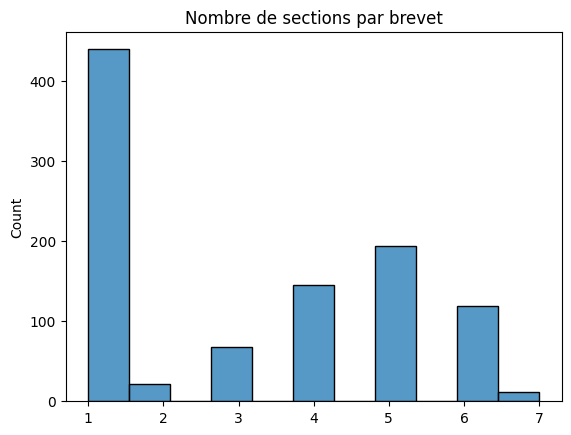

In [8]:
list_nb_sections = [len(corpus_patent_sections[i]) for i in range(len(corpus_patent_sections))]
ax = sns.histplot(data=list_nb_sections)
ax.set_title('Nombre de sections par brevet')

In [16]:
# Nombre de contenu de brevet VS abstract
nb_abstract = 0
for i in corpus_patent_sections.keys():
    patent_sections = corpus_patent_sections[i]
    if (len(patent_sections) == 1) and (patent_sections[0]['section'] == ''):
        nb_abstract+=1
nb_patent_content = len(corpus_patent_sections) - nb_abstract
print('Au total dans le jeud de donnees:')
print('    Nombre de contenus de brevet : {}'.format(nb_patent_content))
print('    Nombre d\'abstracts de brevet: {}'.format(nb_abstract))

Au total dans le jeud de donnees:
    Nombre de contenus de brevet : 564
    Nombre d'abstracts de brevet: 434


In [146]:
Counter(list_nb_sections)

Counter({1: 440, 5: 194, 4: 145, 6: 119, 3: 68, 2: 21, 7: 11})

In [166]:
# Stats sur les sections les plus longues
dic_len_sections = {key:[] for key in list_all_patent_sections+['']}

for i in range(len(corpus_patent_sections)):
    list_sections = corpus_patent_sections[i]
    for section in list_sections:
        key = section['section']
        value = len(section['content'].split())
        dic_len_sections[key].append(value)

for key in dic_len_sections:
    if len(dic_len_sections[key]) == 0:
        dic_len_sections[key] = 0
    else:
        dic_len_sections[key] = np.mean(dic_len_sections[key])

list_len_sections = [(key, value) for key,value in dic_len_sections.items()]

sorted(list_len_sections, key = lambda x : -x[1])

[('DISCLOSURE OF THE INVENTION', 2188.5),
 ('OBJECTS AND SUMMARY OF THE INVENTION', 1688.5),
 ('DETAILED DESCRIPTION OF EMBODIMENTS', 1567.0),
 ('DETAILED DESCRIPTION OF THE PREFERRED EMBODIMENT', 1502.1797752808989),
 ('DETAILED DESCRIPTION OF PREFERRED EMBODIMENTS', 1470.0),
 ('DETAILED DESCRIPTION OF THE INVENTION', 1466.7364864864865),
 ('DETAILED DESCRIPTION', 1449.516393442623),
 ('DESCRIPTION OF PREFERRED EMBODIMENT', 1405.6666666666667),
 ('DESCRIPTION OF THE PREFERRED EMBODIMENT', 1374.7115384615386),
 ('BACKGROUND AND SUMMARY OF THE INVENTION', 1204.4),
 ('DETAILED DESCRIPTION OF THE INVENTION FIG.', 1084.3333333333333),
 ('DESCRIPTION OF THE FIGURES', 943.5714285714286),
 ('BACKGROUND TO THE INVENTION', 882.8),
 ('DESCRIPTION OF THE INVENTION', 813.4285714285714),
 ('BACKGROUND AND PRIOR ART', 794.0),
 ('BRIEF SUMMARY OF THE INVENTION', 755.375),
 ('DISCUSSION OF PRIOR ART', 744.2857142857143),
 ('BACKGROUND OF INVENTION', 739.8),
 ('DESCRIPTION OF THE PRIOR ART', 734.9),
 (

In [18]:
# Comparaison de la longueur moyenne des contenu de brevet VS la longueur moyenne des abstracts
longueur_abstracts = []
longueur_patents = []

for i in corpus_patent_sections.keys():
    patent_sections = corpus_patent_sections[i]
    if (len(patent_sections) == 1) and (patent_sections[0]['section'] == ''):
        nb_words = len(patent_sections[0]['content'].split())
        longueur_abstracts.append(nb_words)
    else:
        nb_words = 0
        for j in range(len(patent_sections)):
            nb_words += len(patent_sections[j]['content'].split())
        longueur_patents.append(nb_words)

longueur_abstracts_mean = int(np.mean(longueur_abstracts))
longueur_patents_mean = int(np.mean(longueur_patents))

print('Longueur moyenne des abstracts : {} mots'.format(longueur_abstracts_mean))
print('Longueur moyenne des contenus de brevet : {} mots'.format(longueur_patents_mean))

Longueur moyenne des abstracts : 216 mots
Longueur moyenne des contenus de brevet : 2711 mots


Les enseignements qu'on en tire de cette analyse par section des brevets :
- Le jeu de donnees est presque equilibre entre les textes sous forme de contenu de brevet et les textes représentant les abstracts
- **Les abstracts sont en moyenne 12 fois moins longs que les contenus de brevet** : points de vigilance quand on fera des embeddings

### Construction d'un dataset par section

Construction d'un dataset par section, qui sera utile pour la modelisation qui suivra.
Le dataset aura cette structure : 

{
1: {'query': '...',
    'pos': patent_sections_pos,
    'negative': }
...
}

In [28]:
dataset_section = {}
for i in range(len(data)):
    dataset_i = {}
    dataset_i['query'] = data[i]['query']
    dataset_i['pos'] = transform_patent_text_to_list_sections(data[i]['pos'])
    dataset_i['negative'] = transform_patent_text_to_list_sections(data[i]['negative'])
    dataset_section[i] = dataset_i

In [31]:
with open("../data/dataset_patent_sections.json", "w") as outfile:
    json.dump(dataset_section, outfile) 
    outfile.close() 